# Facebook Prophet - Air Passengers

In [1]:
# Posibles instalaciones antes de empezar.
# Ejecutar en anaconda (terminal)


# conda install -c anaconda ephem
# conda install -c conda-forge pystan
# conda install -c conda-forge fbprophet

In [2]:
pip install prophet

  Using cached prophet-1.1.5-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached cmdstanpy-1.2.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached matplotlib-3.7.4-cp38-cp38-win_amd64.whl.metadata (5.8 kB)
  Using cached holidays-0.41-py3-none-any.whl.metadata (21 kB)
Using cached prophet-1.1.5-py3-none-win_amd64.whl (13.3 MB)
Using cached cmdstanpy-1.2.0-py3-none-any.whl (93 kB)
Using cached holidays-0.41-py3-none-any.whl (913 kB)
Using cached matplotlib-3.7.4-cp38-cp38-win_amd64.whl (7.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

  Using cached plotly-5.18.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
Using cached plotly-5.18.0-py3-none-any.whl (15.6 MB)
Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [5]:
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from math import sqrt

from prophet import Prophet

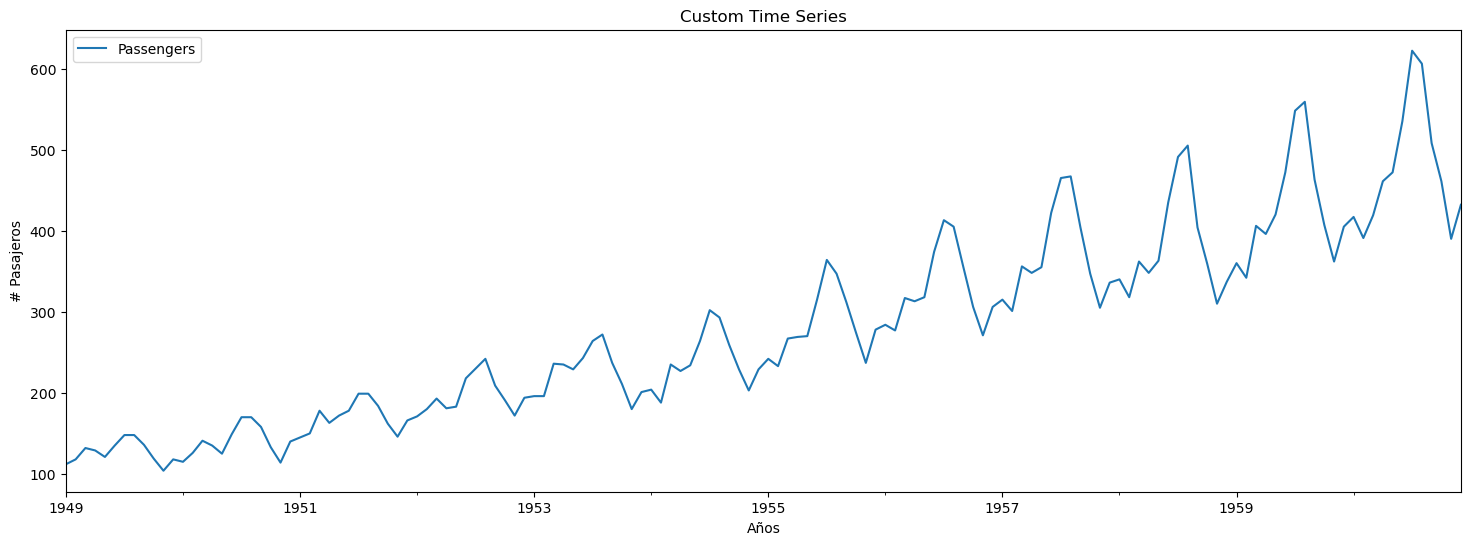

In [6]:
# Cargamos el dataset
real = pd.read_csv('data/AirPassengers.csv', header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

ax = real.plot(figsize=(18,6), title='Custom Time Series');
ax.set_xlabel("Años");
ax.set_ylabel("# Pasajeros");

In [7]:
def splitSet(df, TEST_SIZE):
    
    # Train set
    train_full = df[:(int(len(df)*(1-TEST_SIZE)))]
    train = train_full[:(int(len(train_full)*(1-TEST_SIZE)))]

    # Validation set
    valid = train_full[(int(len(train_full)*(1-TEST_SIZE))):]

    # Test set
    test = df[(int(len(df)*(1-TEST_SIZE))):]

    return train, valid, test

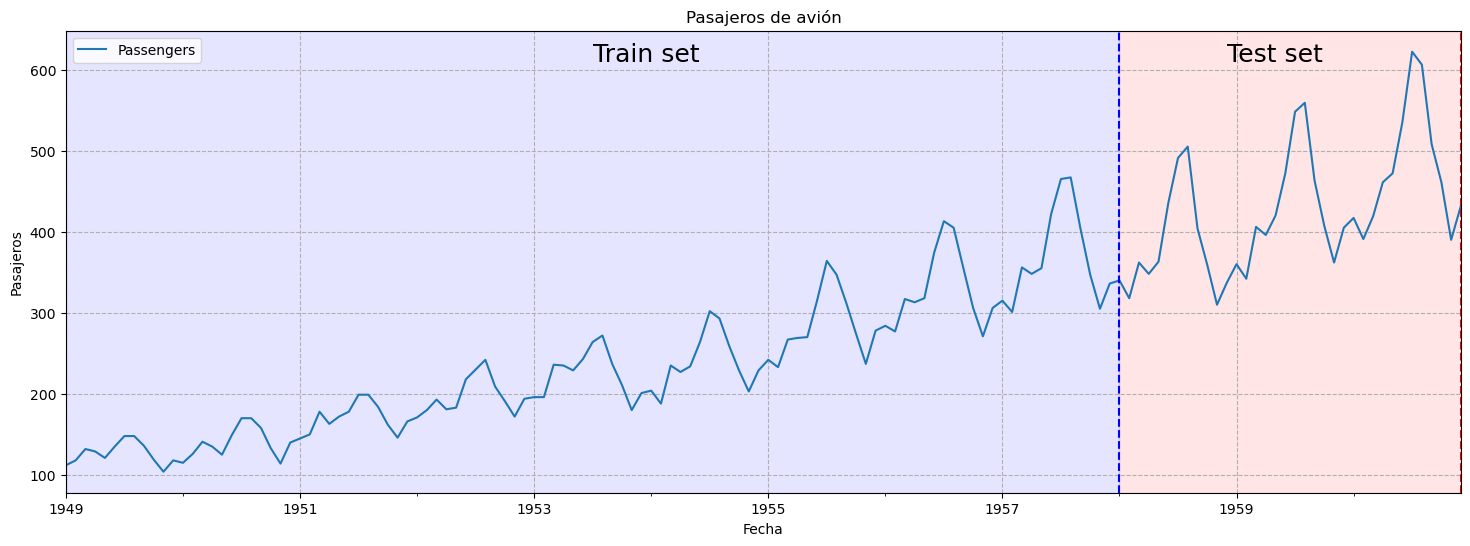

In [8]:
# Split dataset
TEST_SIZE = 0.24
train, valid, test = splitSet(real, TEST_SIZE)

# Trabajamos sólo con train y test
train = pd.concat([train, valid], axis=0)

# Visualización
ax = real.plot(figsize=(18,6), title='Pasajeros de avión');

init__limit = real.index[0]
train_limit = real.index[len(train)-1]
test__limit = real.index[len(train)+len(test)-1]

ax.axvline(train_limit, linestyle='--', color='blue')
ax.axvline(test__limit, linestyle='--', color='red')

ax.axvspan(init__limit, train_limit, alpha=0.1, color='blue')
ax.axvspan(train_limit, test__limit, alpha=0.1, color='red')

ax.text(real.index[int((len(train)-1)*0.5)], 610, 'Train set', fontsize=18)
ax.text(real.index[int(len(train)+(len(test)-1)*0.3)], 610, 'Test set', fontsize=18)

ax.grid(linestyle='--')

ax.set_xlabel("Fecha");
ax.set_ylabel("Pasajeros");

In [9]:
airPassMetrics = pd.DataFrame(columns=['Model', 'RMSE'])

## Facebook Prophet - Simple

20:16:35 - cmdstanpy - INFO - Chain [1] start processing
20:16:35 - cmdstanpy - INFO - Chain [1] done processing


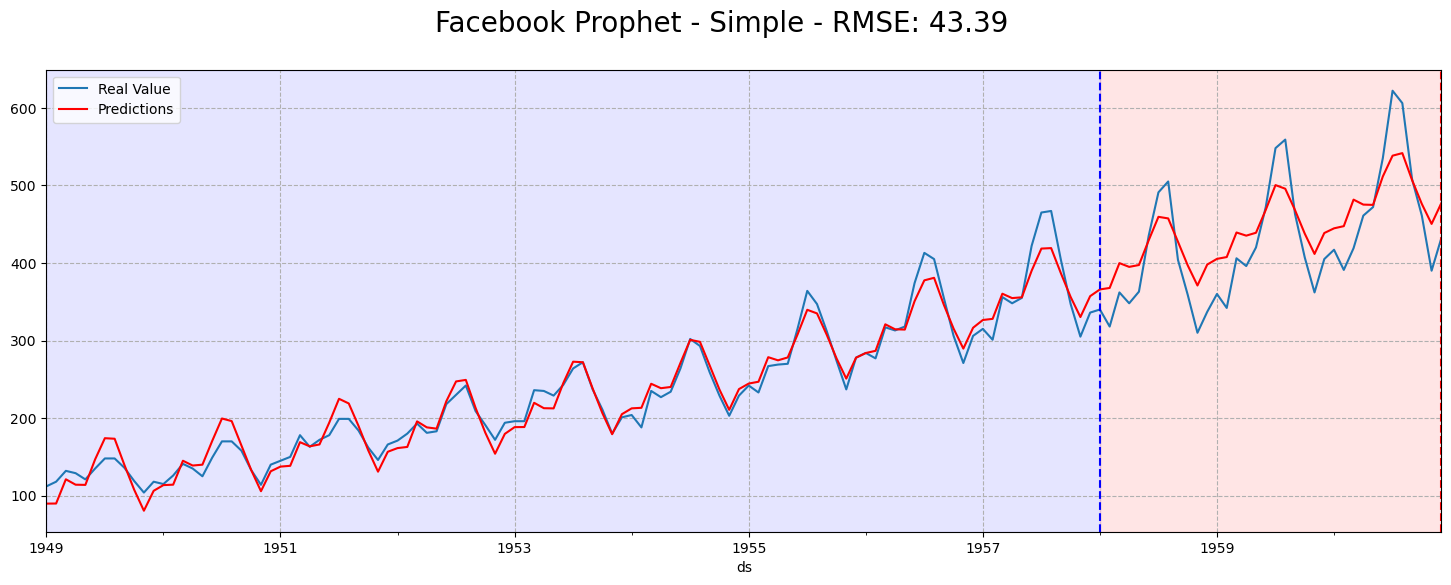

In [10]:
# Model
MODEL = 'Facebook Prophet - Simple'

# Preparing time series for Prophet
real_prophet = pd.DataFrame()
real_prophet['ds'] = real.index
real_prophet['y'] = real['Passengers'].values

train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train['Passengers'].values

test_prophet = pd.DataFrame()
test_prophet['ds'] = test.index
test_prophet['y'] = test['Passengers'].values

# Training model
model = Prophet()

model = model.fit(train_prophet)

# Get Test Set Predictions
predict_test = model.predict(test_prophet)

# Get RMSE from Test Set
real_values = test_prophet['y']
pred_values = predict_test['yhat']
rmse = sqrt(mean_squared_error(real_values, pred_values))

# Get predictions from whole set
predictions = model.predict(real_prophet)

# Preparing data to plot
real_plot = real_prophet['y']
real_plot.index = real_prophet['ds']
pred_plot = predictions['yhat']
pred_plot.index = predictions['ds']

# Visualization
figure(figsize=(18, 6))

real_plot.plot(label='Real Value')
pred_plot.plot(label='Predictions', color='red')
plt.suptitle(MODEL + ' - RMSE: ' + str(np.round(rmse, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'RMSE':np.round(rmse, 3)}
airPassMetrics = airPassMetrics.append(metric_data, ignore_index=True)

## Facebook Prophet - With Parameters

20:16:35 - cmdstanpy - INFO - Chain [1] start processing
20:16:36 - cmdstanpy - INFO - Chain [1] done processing


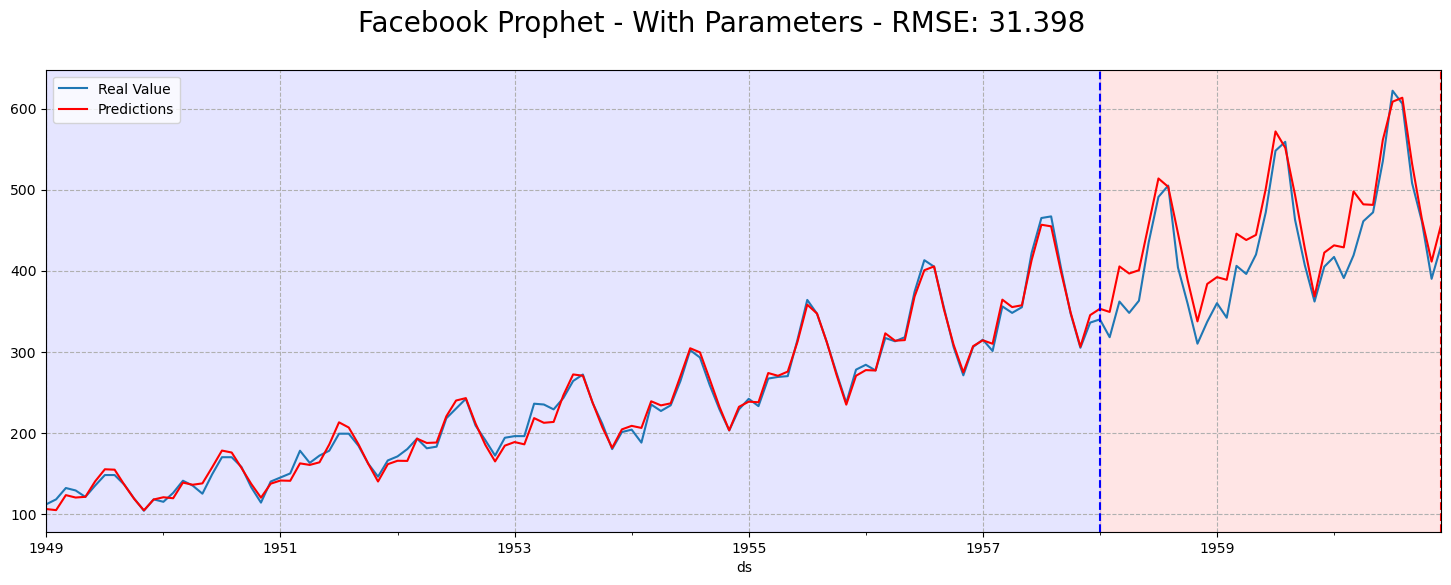

In [11]:
# Model
MODEL = 'Facebook Prophet - With Parameters'

# Preparing time series for Prophet
real_prophet = pd.DataFrame()
real_prophet['ds'] = real.index
real_prophet['y'] = real['Passengers'].values

train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train['Passengers'].values

test_prophet = pd.DataFrame()
test_prophet['ds'] = test.index
test_prophet['y'] = test['Passengers'].values

# Parameters
seasonality_mode = True
daily_seasonality = False
weekly_seasonality = False
montly_seasonality = False
yearly_seasonality = True
decomposition_model = 'multiplicative'

# Training model
model = Prophet(
    daily_seasonality=daily_seasonality,
    weekly_seasonality=weekly_seasonality,
    yearly_seasonality=yearly_seasonality,
    seasonality_mode=decomposition_model
)

model = model.fit(train_prophet)

# Get Test Set Predictions
predict_test = model.predict(test_prophet)

# Get RMSE from Test Set
real_values = test_prophet['y']
pred_values = predict_test['yhat']
rmse = sqrt(mean_squared_error(real_values, pred_values))

# Get predictions from whole set
predictions = model.predict(real_prophet)

# Preparing data to plot
real_plot = real_prophet['y']
real_plot.index = real_prophet['ds']
pred_plot = predictions['yhat']
pred_plot.index = predictions['ds']

# Visualization
figure(figsize=(18, 6))

real_plot.plot(label='Real Value')
pred_plot.plot(label='Predictions', color='red')
plt.suptitle(MODEL + ' - RMSE: ' + str(np.round(rmse, 3)), fontsize=20)
plt.legend();

plt.axvline(train_limit, linestyle='--', color='blue');
plt.axvline(test__limit, linestyle='--', color='red');

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue');
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red');

plt.grid(linestyle='--')

metric_data = {'Model':MODEL, 'RMSE':np.round(rmse, 3)}
airPassMetrics = airPassMetrics.append(metric_data, ignore_index=True)

In [12]:
airPassMetrics.sort_values(by=['RMSE'], ascending=True)

Model    RMSE
1  Facebook Prophet - With Parameters  31.398
0           Facebook Prophet - Simple  43.390

### Output de Facebook Prophet

In [13]:
predictions.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1949-01-01  118.173416   96.415287  115.252116   118.173416   118.173416   
1 1949-02-01  119.530497   95.483707  114.057853   119.530497   119.530497   
2 1949-03-01  120.756248  113.901121  132.330295   120.756248   120.756248   
3 1949-04-01  122.113329  111.362730  129.252891   122.113329   122.113329   
4 1949-05-01  123.426633  111.328852  130.501878   123.426633   123.426633   

   multiplicative_terms  multiplicative_terms_lower  \
0             -0.102582                   -0.102582   
1             -0.123824                   -0.123824   
2              0.020495                    0.020495   
3             -0.015106                   -0.015106   
4             -0.018470                   -0.018470   

   multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                   -0.102582 -0.102582     -0.102582     -0.102582   
1                   -0.123824 -0.123824     -0.123824     -0.123824   
2                    0.020495  0.020495      0.020495      0.020495   
3                   -0.015106 -0.015106     -0.015106     -0.015106   
4                   -0.018470 -0.018470     -0.018470     -0.018470   

   additive_terms  additive_terms_lower  additive_terms_upper        yhat  
0             0.0                   0.0                   0.0  106.050992  
1             0.0                   0.0                   0.0  104.729748  
2             0.0                   0.0                   0.0  123.231102  
3             0.0                   0.0                   0.0  120.268691  
4             0.0                   0.0                   0.0  121.146948

### Forecasting del futuro

In [14]:
# Prepare the whole dataset again
real_prophet = pd.DataFrame()
real_prophet['ds'] = real.index
real_prophet['y'] = real['Passengers'].values

In [15]:
real_prophet.head()

ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121

In [16]:
real_prophet.tail()

ds    y
139 1960-08-01  606
140 1960-09-01  508
141 1960-10-01  461
142 1960-11-01  390
143 1960-12-01  432

In [17]:
# Training model again with whole dataset
model = Prophet(
    daily_seasonality=daily_seasonality,
    weekly_seasonality=weekly_seasonality,
    yearly_seasonality=yearly_seasonality,
    seasonality_mode=decomposition_model
)

model = model.fit(real_prophet)

20:16:36 - cmdstanpy - INFO - Chain [1] start processing
20:16:36 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Creamos años de datos futuros

YEARS = 6
PERIODS = YEARS*12

next_months = model.make_future_dataframe(periods=PERIODS, freq='MS') # MS - start month (M - end month)

next_months.tail(PERIODS+1)

ds
143 1960-12-01
144 1961-01-01
145 1961-02-01
146 1961-03-01
147 1961-04-01
..         ...
211 1966-08-01
212 1966-09-01
213 1966-10-01
214 1966-11-01
215 1966-12-01

[73 rows x 1 columns]

In [19]:
# Forecasting next months
forecast_next = model.predict(next_months)

forecast_next.tail(PERIODS+1)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
143 1960-12-01  491.874065  423.364231  449.751673   491.874065   491.874065   
144 1961-01-01  495.374677  435.284776  463.902977   495.374677   495.374677   
145 1961-02-01  498.875289  416.111246  444.214214   498.821669   498.920184   
146 1961-03-01  502.037132  477.670719  504.510953   501.889530   502.169359   
147 1961-04-01  505.537744  478.387488  505.704875   505.269680   505.746790   
..         ...         ...         ...         ...          ...          ...   
211 1966-08-01  725.511693  873.364584  945.408841   698.776021   752.180381   
212 1966-09-01  729.012306  737.401772  802.762512   701.659088   756.320632   
213 1966-10-01  732.399995  645.298810  705.144969   704.615634   760.024560   
214 1966-11-01  735.900607  558.664766  613.806078   707.552473   764.149315   
215 1966-12-01  739.288296  623.494275  684.336271   710.497292   768.123384   

     multiplicative_terms  multiplicative_terms_lower  \
143             -0.115157                   -0.115157   
144             -0.092145                   -0.092145   
145             -0.136044                   -0.136044   
146             -0.021025                   -0.021025   
147             -0.024898                   -0.024898   
..                    ...                         ...   
211              0.253456                    0.253456   
212              0.056979                    0.056979   
213             -0.078170                   -0.078170   
214             -0.202396                   -0.202396   
215             -0.114357                   -0.114357   

     multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
143                   -0.115157 -0.115157     -0.115157     -0.115157   
144                   -0.092145 -0.092145     -0.092145     -0.092145   
145                   -0.136044 -0.136044     -0.136044     -0.136044   
146                   -0.021025 -0.021025     -0.021025     -0.021025   
147                   -0.024898 -0.024898     -0.024898     -0.024898   
..                          ...       ...           ...           ...   
211                    0.253456  0.253456      0.253456      0.253456   
212                    0.056979  0.056979      0.056979      0.056979   
213                   -0.078170 -0.078170     -0.078170     -0.078170   
214                   -0.202396 -0.202396     -0.202396     -0.202396   
215                   -0.114357 -0.114357     -0.114357     -0.114357   

     additive_terms  additive_terms_lower  additive_terms_upper        yhat  
143             0.0                   0.0                   0.0  435.231264  
144             0.0                   0.0                   0.0  449.728202  
145             0.0                   0.0                   0.0  431.006091  
146             0.0                   0.0                   0.0  491.481797  
147             0.0                   0.0                   0.0  492.950902  
..              ...                   ...                   ...         ...  
211             0.0                   0.0                   0.0  909.397236  
212             0.0                   0.0                   0.0  770.550791  
213             0.0                   0.0                   0.0  675.148632  
214             0.0                   0.0                   0.0  586.957383  
215             0.0                   0.0                   0.0  654.745452  

[73 rows x 16 columns]

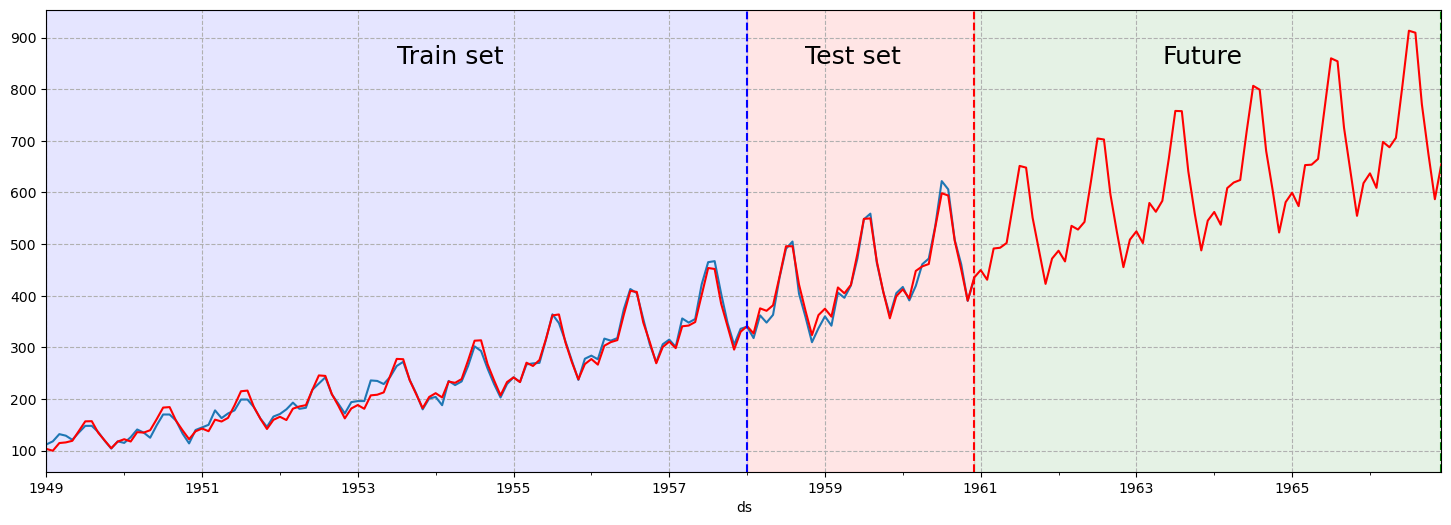

In [20]:
plot = pd.DataFrame()
plot['yhat'] = forecast_next['yhat'].values
plot = pd.concat([plot, real_prophet['y']], ignore_index=True, axis=1)
plot.index = forecast_next['ds']
plot.columns = ['yhat', 'y']

# Visualización
figure(figsize=(18, 6))
plot['y'].plot(label='Real Value')
plot['yhat'].plot(label='Predictions', color='red')

init__limit = plot.index[0]
train_limit = plot.index[len(train)-1]
test__limit = plot.index[len(train)+len(test)-1]
pred__limit = plot.index[len(plot)-1]

plt.axvline(train_limit, linestyle='--', color='blue')
plt.axvline(test__limit, linestyle='--', color='red')
plt.axvline(pred__limit, linestyle='--', color='green')

plt.axvspan(init__limit, train_limit, alpha=0.1, color='blue')
plt.axvspan(train_limit, test__limit, alpha=0.1, color='red')
plt.axvspan(test__limit, pred__limit, alpha=0.1, color='green')

plt.text(plot.index[int((len(train)-1)*0.5)], 850, 'Train set', fontsize=18)
plt.text(plot.index[int((len(train)+(len(test))-1)*0.82)], 850, 'Test set', fontsize=18)
plt.text(plot.index[int((len(train)+(len(test)+len(plot))-1)*0.48)], 850, 'Future', fontsize=18)

plt.grid(linestyle='--')